# Rafael Goldstein

## 1. Template Matching

Finding the U.S. Capitol Dome in a political ads image.

### 1.1 Using `cv2.matchTemplate()` to find the Capital Dome in a political ads image. 


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
temp = cv2.imread('data/template1.png')
test = cv2.imread('data/test.png')

In [3]:
heightD, widthD, channelsD = temp.shape
heightT, widthT, channelsD = test.shape

In [4]:
print('Dimensions of Dome: ' + str(heightD) + ' x ' + str(widthD))
print('Dimensions of Test: ' + str(heightT) + ' x ' + str(widthT))

Dimensions of Dome: 102 x 50
Dimensions of Test: 344 x 360


(<matplotlib.axes._subplots.AxesSubplot at 0x11b002390>,
 <matplotlib.image.AxesImage at 0x11b0587b8>)

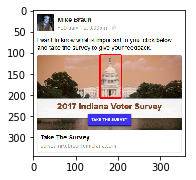

In [5]:
template = cv2.matchTemplate(temp, test, cv2.TM_CCOEFF_NORMED)
a, w, h = temp.shape[::-1]
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(template)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(test,top_left, bottom_right, 255, 2)
plt.subplot(122),plt.imshow(test, cmap = 'gray')

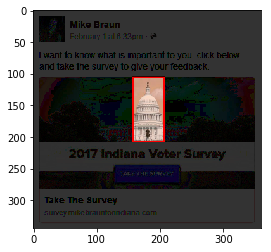

In [6]:
img = test.copy()
alpha = 0.2
mask = np.zeros(img.shape, dtype = 'uint8')
mask = cv2.addWeighted(test, alpha, mask, 1 - alpha, 0, mask)

cv2.rectangle(mask, top_left, bottom_right, (255, 255, 255), -1)

# Apply the mask and display the result
maskedImg = cv2.bitwise_and(img, mask)
plt.imshow(maskedImg)

### 1.2 Multi-scale Template Matching

In the previous question, the dimension of the template image is the same as the Capitol Dome in the political ads image. If the dimension of the template does not match the dimension of the Captial Dome in the political ads, we may be left with a false detection.

To solve this problem, we can use multi-scale template matching. The idea is very straightforward: just loop over the political ads image at multiple scales to find the matched area.

In [5]:
import imutils
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [6]:
temp2 = cv2.imread('data/template2.png')
test2 = cv2.imread('data/test.png')
gray = cv2.cvtColor(temp2, cv2.COLOR_BGR2GRAY)
heightD2, widthD2, channelsD2 = temp2.shape
heightT2, widthT2, channelsT2 = test2.shape
print('Dimensions of Dome: ' + str(heightD2) + ' x ' + str(widthD2))
print('Dimensions of Test: ' + str(heightT2) + ' x ' + str(widthT2))

Dimensions of Dome: 51 x 25
Dimensions of Test: 344 x 360


In [7]:
def canny_img(image):
    sigma = 0.33
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
 
    # return the edged image
    return edged

In [8]:
template = cv2.cvtColor(temp2, cv2.COLOR_BGR2GRAY)
template = canny_img(template)
(tH, tW) = template.shape[:2]

(<matplotlib.axes._subplots.AxesSubplot at 0x12737fb38>,
 <matplotlib.image.AxesImage at 0x127cd5400>)

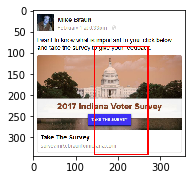

In [9]:
import cv2
gray = cv2.cvtColor(test2, cv2.COLOR_BGR2GRAY)

# loop over the scales of the image
for scale in np.linspace(0.2, 1.0, 20)[::-1]:
    resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
    r = gray.shape[1] / float(resized.shape[1])
    # if the resized image is smaller than the template, then break
    # from the loop
    if resized.shape[0] < tH or resized.shape[1] < tW:
        break
edged = canny_img(resized) 
result = cv2.matchTemplate(resized, template, cv2.TM_CCOEFF_NORMED)
(_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)

(startX, startY) = (int((maxLoc[0] * r)), int((maxLoc[1] * r)))
(endX, endY) = (int(((maxLoc[0] + tW) * r)), int(((maxLoc[1] + tH) * r)))

# draw a bounding box around the detected result and display the image
cv2.rectangle(test2, (startX, startY), (endX, endY), 255, 2)
plt.subplot(122),plt.imshow(test2, cmap = 'gray')

## 2. Feature Extraction and Matching

Although the above code help us handle variations in scaling, the template matching will not be robust to changes in rotation and non-affine transformations. To take care of rotation and non-affine transformations, we need to detect keypoints, extract local invariant descriptors, and apply keypoint matching.

In general, feature matching involves two steps: 1) find the keypoints and descriptors, and 2) apply a matching alogrithm. In this question, we will use SIFT and ORB to identify the keypoints and descriptors, and then apply **Brute-Force matcher** for feature matching.

### 2.1 Scale Invariant Feature Transform (SIFT) 

#### 2.1.1 SIFT feature visualization

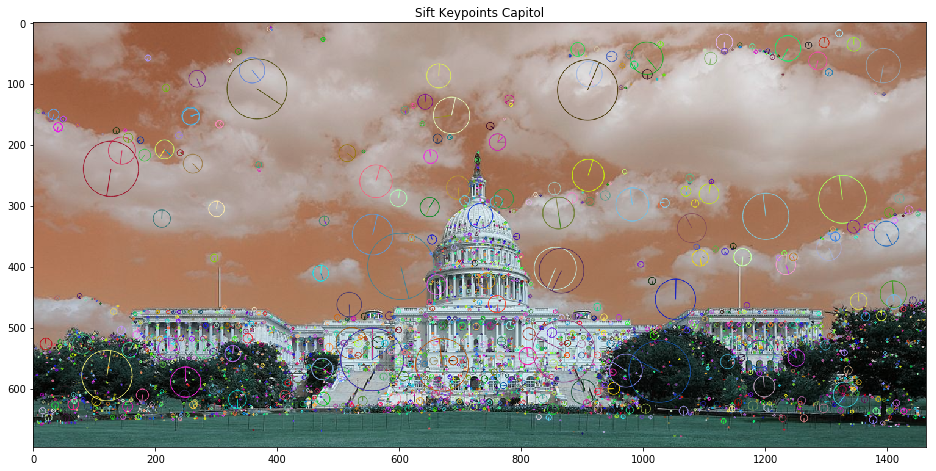

(<matplotlib.image.AxesImage at 0x11b5f8470>, None)

In [12]:
capitol = cv2.imread('data/capitol1.png')
sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(capitol, None)
img = cv2.drawKeypoints(capitol,kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(16,16))
plt.title('Sift Keypoints Capitol')
plt.imshow(img), plt.show()

#### 2.1.2 Brute-Force Matching with SIFT Descriptors

Now let's see how to match features in one image with another based on SIFT descriptors.

In [13]:
cap1 = cv2.imread('data/capitol1.png')
cap2 = cv2.imread('data/capitol2.png')
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(cap1,None)
kp2, des2 = sift.detectAndCompute(cap2,None)

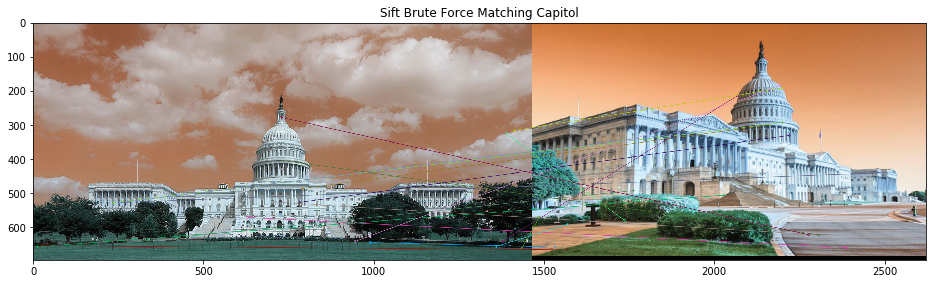

(<matplotlib.image.AxesImage at 0x10402f978>, None)

In [14]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(cap1,kp1,cap2,kp2,matches[:20], None, flags=2)
plt.figure(figsize=(16,16))
plt.title('Sift Brute Force Matching Capitol')
plt.imshow(img3), plt.show()

### 2.2  Oriented FAST and Rotated BRIEF (ORB) 

ORB is a good alternative to SIFT and SURF in computation cost and matching performance. The most important thing about the ORB is that it came from “OpenCV Labs”. This algorithm was brought up by Ethan Rublee, Vincent Rabaud, Kurt Konolige and Gary R. Bradski in their paper ORB: An efficient alternative to SIFT or SURF in 2011. Unlike SIFT and SURF, it's free!

Reference: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html

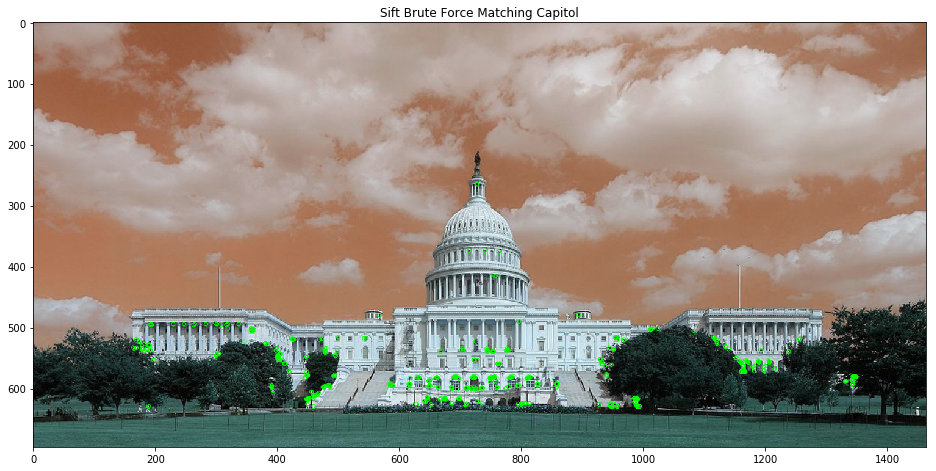

(<matplotlib.image.AxesImage at 0x11b5bdbe0>, None)

In [15]:
capitol = cv2.imread('data/capitol1.png')
orb = cv2.ORB_create()
kp, des = orb.detectAndCompute(capitol, None)
img2 = cv2.drawKeypoints(capitol, kp, None, color=(0,255,0), flags=0)
plt.figure(figsize=(16,16))
plt.title('Sift Brute Force Matching Capitol')
plt.imshow(img2), plt.show()

#### 2.2.2 ORB feature matching (3 points)

Reference: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html

Now let's see if we can match ORB features from two images of the Capitol taken from a different angle. To improve our code, let's create two functions - one for detecting key points and computing descriptors, and the other for drawing image matches.

- Use two images of the Capitol (**capitol1.png** and **capitol2.png**)
- Create a function for detecting key points and computing descriptors.
- Create a function for drawing image matches. Use Brute-Force matching with ORB descriptors: 1) create BFMatcher object 2) match ORB descriptors, 3) Sort them in the order of their distance, and 4) Draw first **20** matches. Change the figure size to figsize=(16,16) and add a title to the figure.

- Call the function for drawing image matches to show the result.
 

In [16]:
cap1 = cv2.imread('data/capitol1.png')
cap2 = cv2.imread('data/capitol2.png')

In [17]:
def detect(img1, img2):
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)
    return kp1, des1, kp2, des2

In [18]:
def drawMatches(kp1, des1, kp2, des2, img1, img2): 
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)
    matches = sorted(matches, key = lambda x:x.distance)
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:20], None, flags=2)
    plt.figure(figsize=(16,16))
    plt.title('ORB Feature Matching Capitol')
    plt.imshow(img3), plt.show()

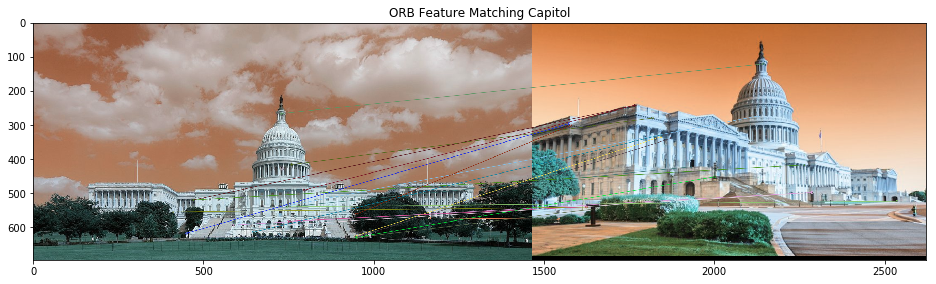

In [19]:
kp1, des1, kp2, des2 = detect(cap1, cap2)
drawMatches(kp1,des1,kp2,des2,cap1,cap2)

## 3. Haar Classifiers v.s. LBP Classifiers

In class, we discussed how to train on hundreds of positive and negative images in order to classify a new image correctly. Particularly, we learned the Viola-Jones detector which uses Haar features to help us find faces in an image. As shown in class, the Viola-Jones detector is easy to use as OpenCV provides a pre-built Haar feature based cascade classifier for face detection. 

In this question, we are going to use another pre-built classifier for face detection: the **Local Binary Patterns (LBP)** cascade classifier. The LBP idea was introduced by Ojala et al. in 2002. While the details can be found in their article, LBP is simply an algorithm that computes a local representation of texture. First, for a 3×3 neighborhood, it compares each pixel with its surrounding neighborhood of pixels and generates eight binary values based on whether the intensity of the center pixel is greater-than-or-equal to its neighbors. Then it stores the result of the eight binary test into an 8-bit array and convert the array to decimal for each pixal. Finally, it constructs a 256-bin histogram of LBP codes as the final feature vector.

Fortunately, OpenCV also provides a handy pre-built LBP feature based cascade classifier for face detection. You can just your code for Haar Classifier except using the LBP training file rather than the Haar classifier training file.

### 3.1 Use OpenCV's Haar Classifier and LBP Classifiers to detect faces ( 4 points)

- The LBP XML training file can be found in `/anaconda3/envs/Python3/share/OpenCV/lbpcascades/lbpcascade_frontalface.xml` 

- Use the two classifiers to detect faces in **image.png**
- Tune the scaleFactor parameter to get the best result.

In [20]:
import time
def lbp_classifier(img):
    begin = time.time()
    lbp_training = cv2.CascadeClassifier('lbpcascade_frontalface.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = lbp_training.detectMultiScale(gray, 1.05, 3)
    for (x,y,w,h) in faces: 
        img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2) 
    print('Time taken: ' + str(time.time() - begin))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def haar_classifier(img):
    begin = time.time()
    haar_training = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = haar_training.detectMultiScale(gray, 1.05, 3)
    for (x,y,w,h) in faces: 
        img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2) 
    print('Time taken: ' + str(time.time() - begin))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [21]:
img = cv2.imread('data/image.png')

Time taken: 0.03774213790893555


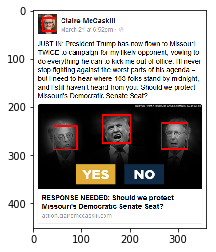

In [22]:
plt.imshow(lbp_classifier(img))

Time taken: 0.126237154006958


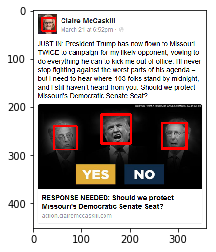

In [23]:
plt.imshow(haar_classifier(img))

### 3.2 Compare the performance of Haar Classifiers and LBP Classifiers (4 points)

Based on the three example images (**image1.png, image2.png, image3.png**), which classifier is faster and which is more accurate. 

- You can create your own measure to compare accuracy
- You can use `time.time()` to keep track of time


In [24]:
img1 = cv2.imread('data/image1.png')
img2 = cv2.imread('data/image2.png')
img3 = cv2.imread('data/image3.png')

Time taken: 0.17927908897399902


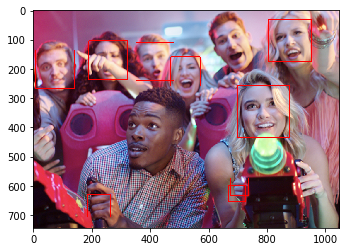

In [25]:
plt.imshow(lbp_classifier(img1))

Time taken: 0.46610283851623535


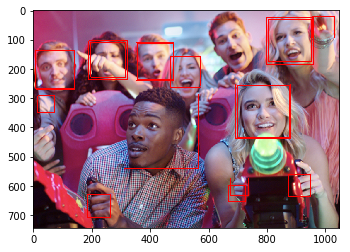

In [26]:
plt.imshow(haar_classifier(img1))

Time taken: 0.2153151035308838


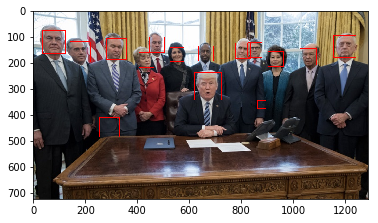

In [27]:
plt.imshow(lbp_classifier(img2))

Time taken: 0.5045120716094971


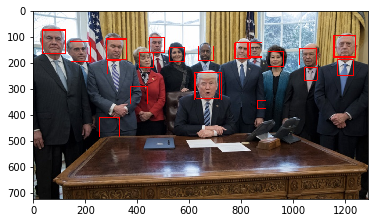

In [28]:
plt.imshow(haar_classifier(img2))

Time taken: 0.15802288055419922


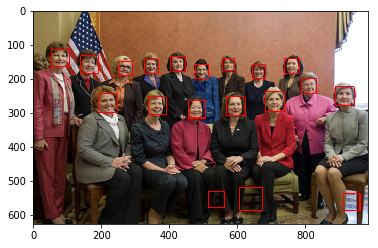

In [29]:
plt.imshow(lbp_classifier(img3))

Time taken: 0.41381311416625977


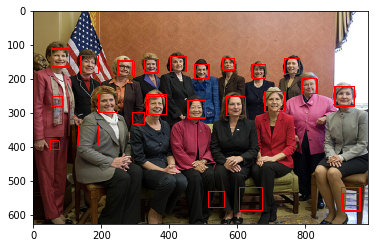

In [30]:
plt.imshow(haar_classifier(img3))

# Compare performance

It appears, based on how often their are false positives, as well as how often all of the faces are detected, that the haar method is more accurate. However, the haar method takes more time, as exhibited by the times that were printed out. Therefore, for maximum efficiency, use the lbp method, and for maximum accuracy, use the haar method.